## Итоговая работа
## 12448/1 ИНЖДАН МГТУ им. Н.Э. Баумана
## Инженер данных (Data engineer)
## Андреев Андрей Анатольевич



## КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.

Иногда контракт может относиться одновременно в несколько групп.

В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

# Шаг 2 - Разведочный  анализ данных

In [2]:
! pip install pandas
! pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

In [4]:
filename = 'datasets/dataset.csv'

columns = ['id', 'contract_number', 'object_name', 'object_code', 'cost', 'contract_execution_days']

dtypes = {'id': lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_number': str, 
          'object_name': str,
          'object_code': str, 
          'cost':lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_execution_days': lambda x: pd.to_numeric(x, errors="coerce")}

df = pd.read_csv(filename,  on_bad_lines='skip', low_memory=False, sep=';') 

In [5]:
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days
0,137313,2590229330821001063,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,21
1,137314,2590229330821001064,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,18
2,137315,2590229330821001065,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,18
3,137320,2590229330821001067,"Средства лекарственные и материалы, применяемы...",21.2,26457423.22,389
4,137321,2590229330821001067,"Средства лекарственные и материалы, применяемы...",21.2,26457423.22,389


In [6]:
df.dtypes

id                           int64
contract_number              int64
object_name                 object
object_code                 object
cost                       float64
contract_execution_days      int64
dtype: object

In [7]:
df['object_name']  = df['object_name'].astype('string')
df['object_code']  = df['object_code'].astype('string')
df['object_code']  = df['object_code'].apply(lambda x: x.strip())
df.dtypes

id                                  int64
contract_number                     int64
object_name                string[python]
object_code                        object
cost                              float64
contract_execution_days             int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040970 entries, 0 to 18040969
Data columns (total 6 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       int64  
 1   contract_number          int64  
 2   object_name              string 
 3   object_code              object 
 4   cost                     float64
 5   contract_execution_days  int64  
dtypes: float64(1), int64(3), object(1), string(1)
memory usage: 825.9+ MB


In [9]:
df.describe()

,id,contract_number,cost,contract_execution_days
count,1.804097e+07,1.804097e+07,1.804097e+07,1.804097e+07
mean,1.562675e+07,2.764142e+18,3.011627e+06,2.190790e+02
std,1.024351e+07,7.059406e+17,1.487401e+08,2.005745e+02
min,1.373130e+05,1.423000e+17,-8.573584e+07,-3.650000e+02
25%,6.631687e+06,2.365000e+18,4.197560e+04,9.300000e+01
50%,1.463643e+07,2.773317e+18,1.581423e+05,1.940000e+02
75%,2.375647e+07,3.366103e+18,5.992457e+05,3.380000e+02
max,3.509658e+07,4.920456e+18,1.425579e+11,7.324800e+04


In [10]:
# Проверим null значения
df.isna().sum()

id                         0
contract_number            0
object_name                0
object_code                0
cost                       0
contract_execution_days    0
dtype: int64

In [11]:
# Проверим на уникальные значения
df.nunique()

id                         18040970
contract_number            14248182
object_name                     366
object_code                     294
cost                        7613237
contract_execution_days        3625
dtype: int64

In [12]:
duplicated_registy_numbers = df[df['contract_number'].duplicated(keep=False)].sort_values(by='contract_number')
print(duplicated_registy_numbers[['contract_number','object_code']].head(20))

full_duplicates = duplicated_registy_numbers.duplicated(keep=False).sum()
partial_duplicates = len(duplicated_registy_numbers) - full_duplicates

print('Полных дупликатов:', full_duplicates)
print('Частичных дупликатов: ', partial_duplicates)

              contract_number object_code
4677093    172200003114000131        37.0
4677094    172200003114000131        37.0
4677095    172200003114000140        37.0
4677096    172200003114000140        37.0
7279583    340300119314000001        41.2
7279582    340300119314000001        41.2
13051884  1010100225118000001        35.1
13051885  1010100225118000001        35.1
10066873  1010100225118000004        53.2
10066874  1010100225118000004        53.2
798061    1010100225118000020        38.1
798062    1010100225118000020        38.1
5488924   1010100225119000004        35.1
5488925   1010100225119000004        35.1
5488927   1010100225119000005        35.1
5488926   1010100225119000005        35.1
5488928   1010100225119000005        35.1
5488930   1010100225119000007        35.3
5488931   1010100225119000007        35.3
5488933   1010100225119000009        36.0
Полных дупликатов: 0
Частичных дупликатов:  5762362


Видно, что один и тотже контракт имеет несколько кодов обновременно. Возможно это ошибки. Не обходимо уточнить это у специалиста в предметной области.

In [13]:
code_counts = df.groupby(['object_code', 'object_name']).size().reset_index(name='count')
code_counts

,object_code,object_name,count
0,01.1,01.1,32591
1,01.1,<НЕ ОПРЕДЕЛЕНО>,310
2,01.2,01.2,14604
3,01.2,<НЕ ОПРЕДЕЛЕНО>,171
4,01.3,01.3,670
...,...,...,...
1044,nan,93.1,1
1045,nan,93.2,5
1046,nan,94.1,1
1047,nan,95.1,4


In [14]:
grouped_data = df.groupby('object_code')['object_name'].nunique()

multiple_descriptions = grouped_data[grouped_data > 1]
multiple_descriptions

object_code
01.1      2
01.2      2
01.3      2
01.4      2
01.6      2
       ... 
96.0      3
97.0      2
98.1      2
99.0      2
nan     150
Name: object_name, Length: 257, dtype: int64

In [15]:
df.duplicated().sum()

0

Коды ОКПД-2 имеют больше одного наименования.

In [16]:
df.sort_values(ascending=False, by='cost')

,id,contract_number,object_name,object_code,cost,contract_execution_days
17900416,34874361,2772838158719000703,42.1,42.1,1.425579e+11,1497
10310646,17164742,2910216470217000041,Сооружения и строительные работы в области гра...,42.1,1.387754e+11,1139
10310645,17164741,2910216470217000041,Сооружения и строительные работы в области гра...,42.1,1.387754e+11,1139
10310644,17164740,2910216470217000041,Сооружения и строительные работы в области гра...,42.1,1.387754e+11,1139
16524581,33113347,2770203815020000913,30.2,30.2,1.354438e+11,1208
...,...,...,...,...,...,...
12280078,21353199,3231108310917000104,42.9,nan,-1.339966e+07,17
12280077,21353197,3231108310917000104,42.9,nan,-1.339966e+07,17
10051478,16671997,3720225049320000007,42.1,nan,-3.404144e+07,15
10051477,16671995,3720225049320000007,42.1,nan,-3.404144e+07,15


In [17]:
low_price = df[df['cost'] < 2000].sort_values(by='cost')
low_price

,id,contract_number,object_name,object_code,cost,contract_execution_days
17973010,34964879,3637700528221000024,43.9,nan,-85735835.47,6
10051477,16671995,3720225049320000007,42.1,nan,-34041441.48,15
10051478,16671997,3720225049320000007,42.1,nan,-34041441.48,15
12280078,21353199,3231108310917000104,42.9,nan,-13399664.82,17
12280077,21353197,3231108310917000104,42.9,nan,-13399664.82,17
...,...,...,...,...,...,...
17541478,34184392,2362000129622000148,21.2,21.2,1999.98,250
2537027,3823419,3310600510016000005,"Электроэнергия, газ, пар и кондиционирование в...",35.1,1999.98,9
3689970,5588555,2440100458517000114,"Машины и оборудование, не включенные в другие ...",28.2,1999.99,62
9335563,15112478,2744704182820000266,Услуги в области образования,85.1,1999.99,239


Видно, что стоимость контракта может быть отрицательным.  Надо этот вопрос уточнить у специалиста из предметной области. Для дальнейшего исседования возьмем только положительные стоимости контрактов.

In [18]:
low_price.groupby('object_code')['object_code'].count()

object_code
01.1     204
01.2      60
01.4     111
02.2       4
02.4       1
        ... 
95.2      19
96.0     871
98.1       2
99.0      16
nan     2375
Name: object_code, Length: 240, dtype: int64

In [19]:
df.describe()

,id,contract_number,cost,contract_execution_days
count,1.804097e+07,1.804097e+07,1.804097e+07,1.804097e+07
mean,1.562675e+07,2.764142e+18,3.011627e+06,2.190790e+02
std,1.024351e+07,7.059406e+17,1.487401e+08,2.005745e+02
min,1.373130e+05,1.423000e+17,-8.573584e+07,-3.650000e+02
25%,6.631687e+06,2.365000e+18,4.197560e+04,9.300000e+01
50%,1.463643e+07,2.773317e+18,1.581423e+05,1.940000e+02
75%,2.375647e+07,3.366103e+18,5.992457e+05,3.380000e+02
max,3.509658e+07,4.920456e+18,1.425579e+11,7.324800e+04


Также длительности контракта имеют отрицательные и очень большие значения. Отбросим все эти значения.

In [20]:
df = df.query('(contract_execution_days > 0 and contract_execution_days <= 2000) and cost > 0')
df.describe()

,id,contract_number,cost,contract_execution_days
count,1.797784e+07,1.797784e+07,1.797784e+07,1.797784e+07
mean,1.560977e+07,2.764368e+18,2.710053e+06,2.180765e+02
std,1.022939e+07,7.058635e+17,1.242874e+08,1.567013e+02
min,1.373130e+05,1.423000e+17,1.000000e-02,1.000000e+00
25%,6.630193e+06,2.365000e+18,4.200000e+04,9.400000e+01
50%,1.462914e+07,2.773364e+18,1.580395e+05,1.950000e+02
75%,2.373556e+07,3.366104e+18,5.981897e+05,3.390000e+02
max,3.509658e+07,4.920456e+18,1.425579e+11,2.000000e+03


In [21]:
df.drop_duplicates(subset=['contract_number'], inplace=True)
df = df.dropna()

In [22]:
df.describe()

,id,contract_number,cost,contract_execution_days
count,1.419779e+07,1.419779e+07,1.419779e+07,1.419779e+07
mean,1.591788e+07,2.751354e+18,2.201673e+06,2.204985e+02
std,1.029077e+07,7.006991e+17,9.988996e+07,1.534003e+02
min,1.373130e+05,1.423000e+17,1.000000e-02,1.000000e+00
25%,6.804842e+06,2.360900e+18,3.825000e+04,9.600000e+01
50%,1.489233e+07,2.772393e+18,1.497160e+05,2.000000e+02
75%,2.398329e+07,3.343301e+18,5.626637e+05,3.430000e+02
max,3.509658e+07,4.920456e+18,1.425579e+11,2.000000e+03


In [23]:
df.to_csv('datasets/dataset_clean.csv', sep=';', index=False)

### Корреляционный анализ

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

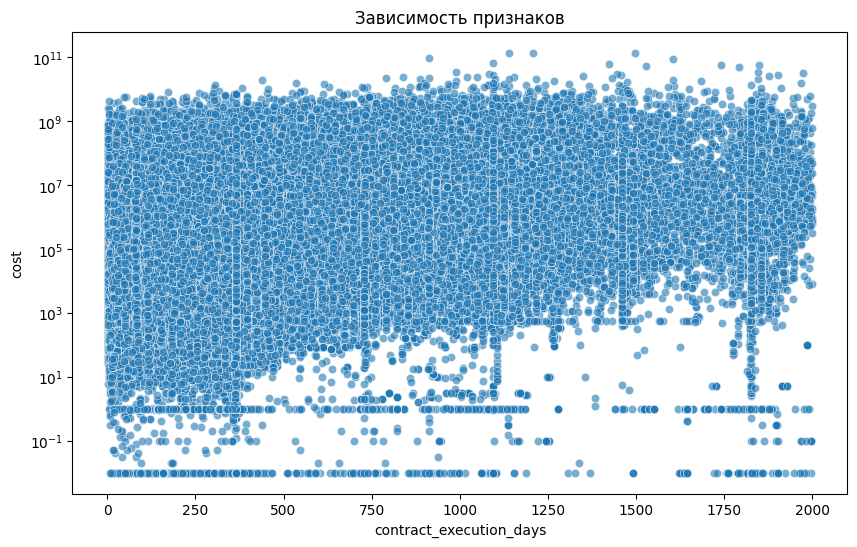

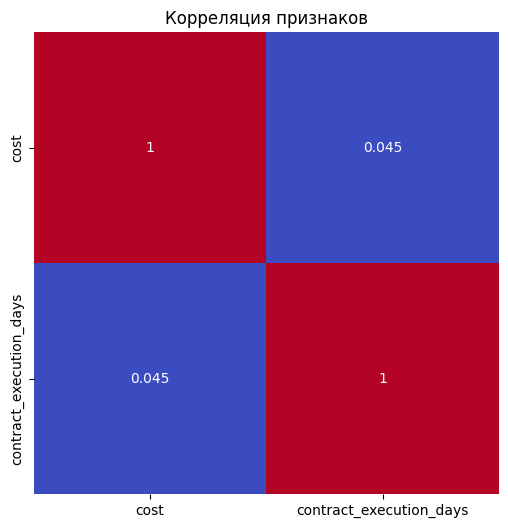

In [25]:
correlation = df[['cost', 'contract_execution_days']].corr()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='contract_execution_days', y='cost', alpha=0.6)
plt.title('Зависимость признаков')
plt.yscale('log')
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=False)
plt.title('Корреляция признаков')
plt.show()

Корреляция очень низкая, в большинстве случаях стоимость закупки не зависит от периода выполнения.

### Анализ кодов ОКПД-2

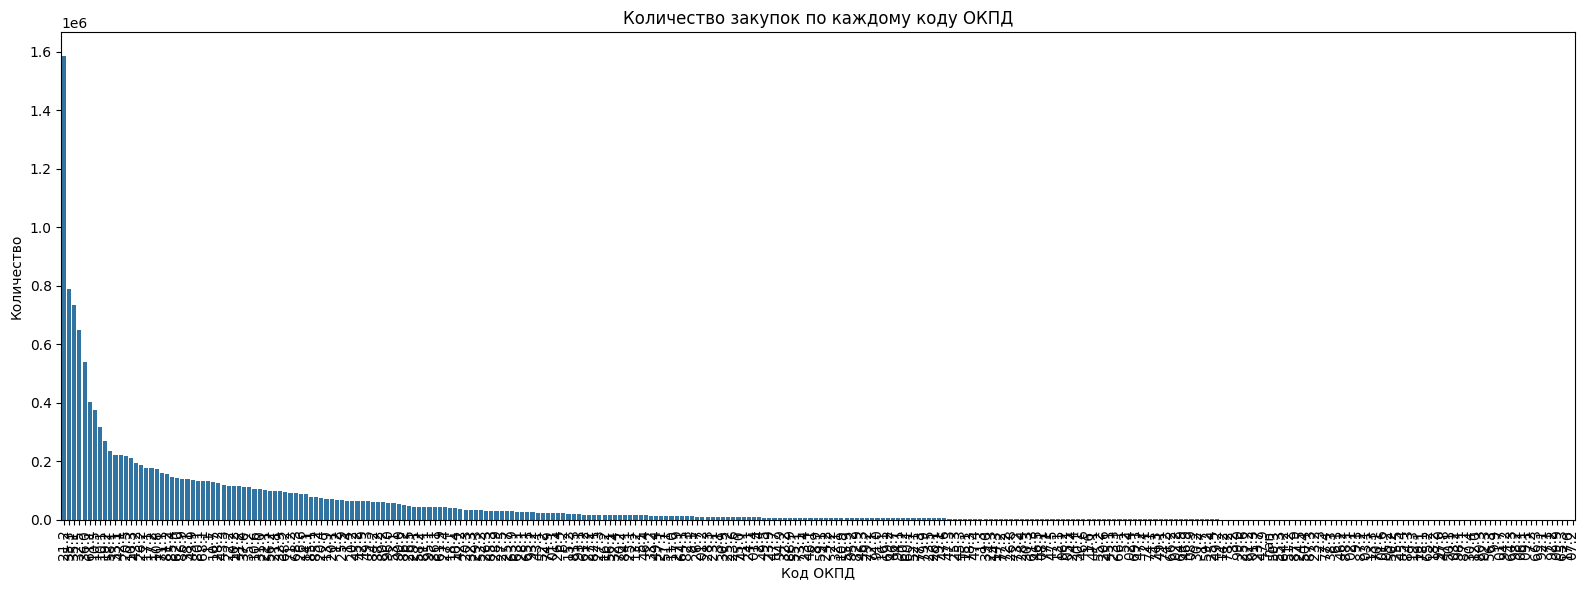

In [26]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='object_code', order=df['object_code'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

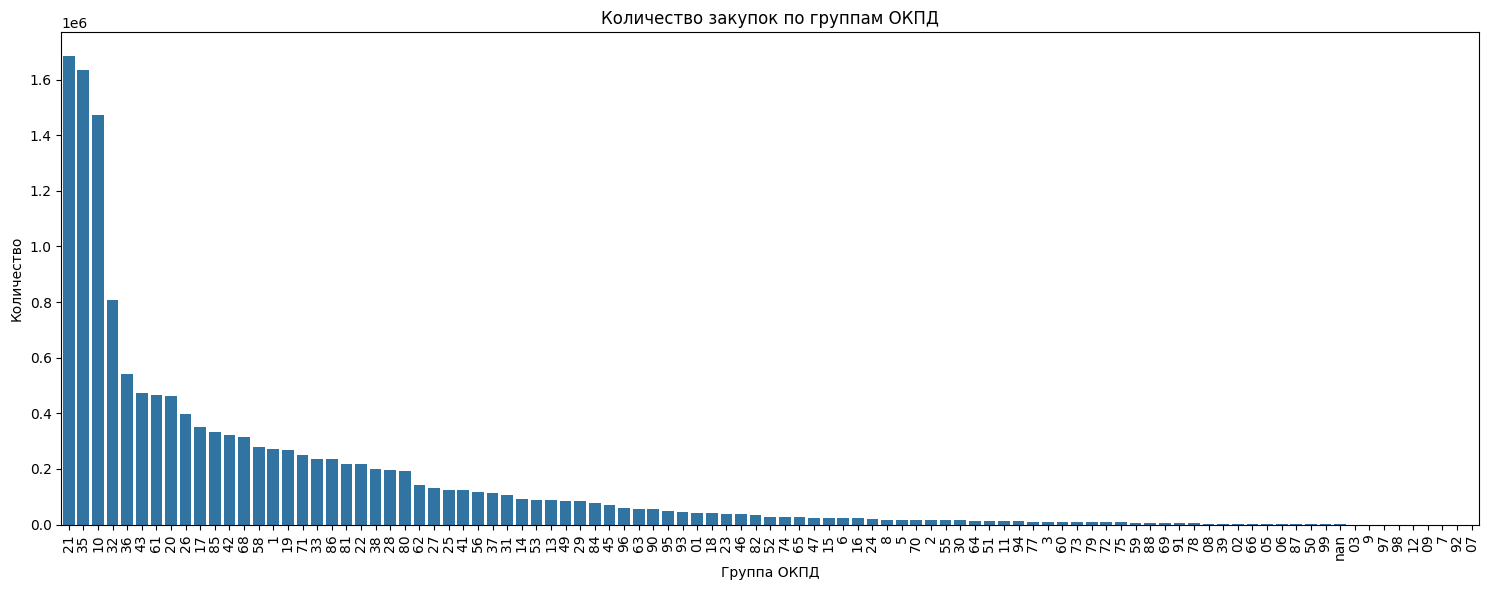

In [29]:

df['code_int'] = df['object_code'].apply(lambda x: '.'.join(x.split('.')[:1]))

plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='code_int', order=df['code_int'].value_counts().index)
plt.title('Количество закупок по группам ОКПД')
plt.xlabel('Группа ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [30]:
df.groupby('code_int')['object_name'].nunique()

code_int
01      7
02      5
03      2
05      3
06      2
       ..
96      3
97      2
98      2
99      2
nan    56
Name: object_name, Length: 97, dtype: int64

In [32]:
grouped_data_int = df.groupby('code_int').agg(
    max_price=('cost', 'max'),
    avg_price=('cost', 'mean'),
    min_price=('cost', 'min'),
    max_duration=('contract_execution_days', 'max'),
    avg_duration=('contract_execution_days', 'mean'),
    min_duration=('contract_execution_days', 'min')).reset_index()
grouped_data_int

,code_int,max_price,avg_price,min_price,max_duration,avg_duration,min_duration
0,01,3.196338e+08,4.170036e+05,6.00,1496,185.305946,1
1,02,2.774177e+08,2.023003e+06,1280.00,1565,205.014629,1
2,03,2.376667e+08,1.422374e+06,644.98,782,180.448378,16
3,05,2.844852e+08,2.330695e+06,10679.67,1660,174.232372,1
4,06,4.535299e+09,3.650299e+06,132.79,1917,379.315259,12
...,...,...,...,...,...,...,...
92,96,6.225000e+08,7.321778e+05,0.01,1869,248.891645,1
93,97,9.892311e+06,4.160971e+05,6500.00,405,278.970297,18
94,98,8.824825e+06,3.075919e+05,139.12,369,125.666667,2
95,99,3.000000e+07,4.322703e+05,100.00,1095,242.298578,2


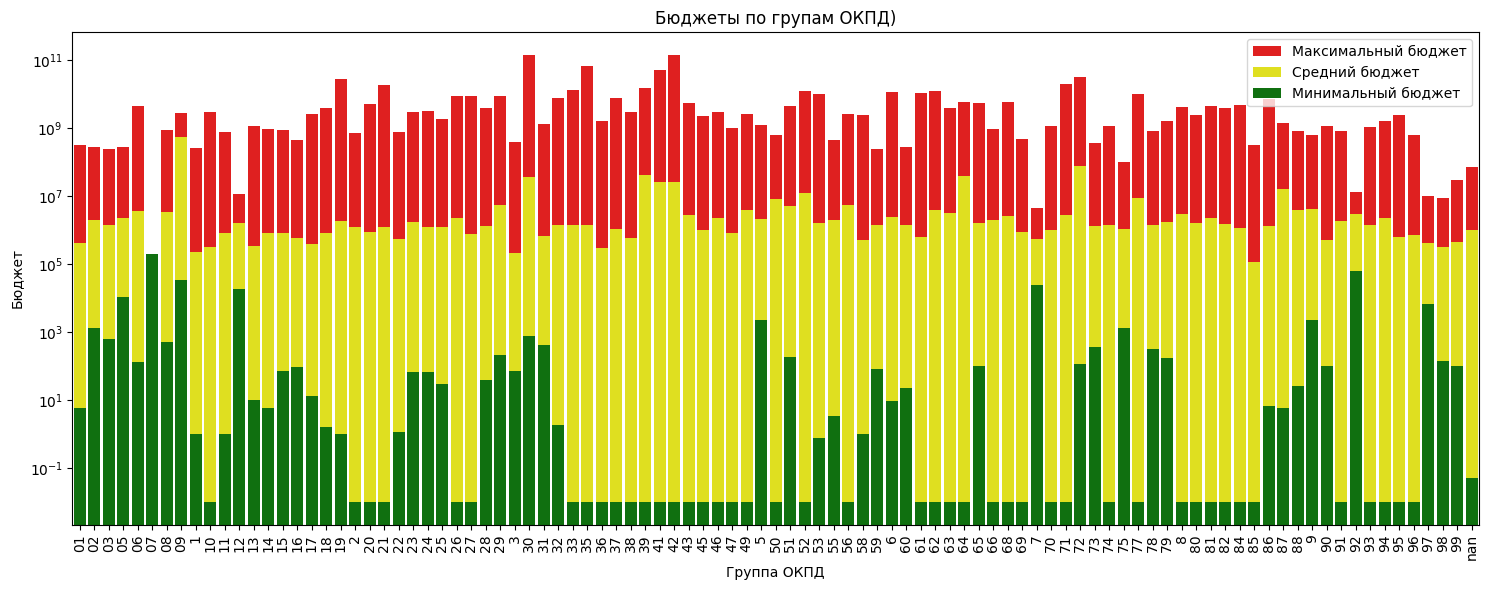

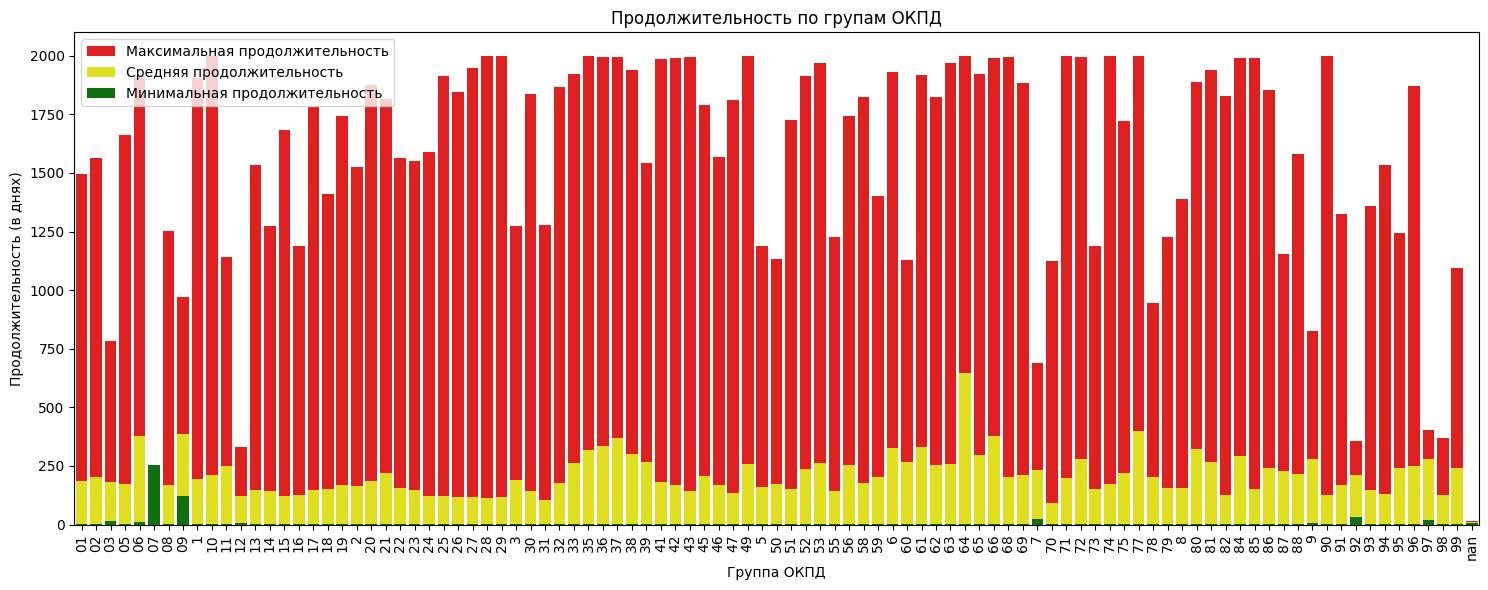

In [33]:
plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='code_int', y='max_price', color='red', label='Максимальный бюджет')
sns.barplot(data=grouped_data_int, x='code_int', y='avg_price', color='yellow', label='Средний бюджет')
sns.barplot(data=grouped_data_int, x='code_int', y='min_price', color='green', label='Минимальный бюджет')
plt.title('Бюджеты по групам ОКПД)')
plt.xlabel('Группа ОКПД')
plt.ylabel('Бюджет')
plt.legend()
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='code_int', y='max_duration', color='red', label='Максимальная продолжительность')
sns.barplot(data=grouped_data_int, x='code_int', y='avg_duration', color='yellow', label='Средняя продолжительность')
sns.barplot(data=grouped_data_int, x='code_int', y='min_duration', color='green', label='Минимальная продолжительность')
plt.title('Продолжительность по групам ОКПД')
plt.xlabel('Группа ОКПД')
plt.ylabel('Продолжительность (в днях)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()